In [72]:
import os
import torch
import torchvision.models as models
import torch.nn as nn
# from deepproblog.dataset import Dataset, DataLoader, QueryDataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as TorchDataset
from deepproblog.dataset import Dataset as DPLDataset
from problog.logic import Term, Constant, Var, list2term
from deepproblog.dataset import ImageDataset
from deepproblog.evaluate import get_confusion_matrix
from torch.amp.autocast_mode import autocast
from torchvision import models, transforms, datasets
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from deepproblog.dataset import DataLoader as DPLDataLoader

import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from deepproblog.utils.stop_condition import EpochStop
from deepproblog.optimizer import SGD

from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.engines import ExactEngine
from deepproblog.query import Query
from deepproblog.train import train_model
import torch.nn as nn
import torch.nn.functional as F

from torch.amp.grad_scaler import GradScaler
from torch.amp.autocast_mode import autocast

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import glob
from retinaface import RetinaFace
import csv

In [73]:
# GLOBAL VARS
dataset_size = None
lr_faces = 1e-4
lr_scenes = 1e-4
lr_combination_model = 5e-4
lr_model = 1e-4
batch_size = 32
log_iter = 2
epochs = 30
global_emotion_label = 'emo8'
nr_clusters = 9

In [74]:
# Directories
script_dir = os.getcwd()
print("script_dir:", script_dir)
base_dir = os.path.dirname(os.path.dirname(script_dir))
print("base_dir:", base_dir)
prolog_dir = os.path.join(base_dir, "prolog")
data_dir = os.path.join(base_dir, "data")
print("data_dir:", data_dir)
findingemo_dir = os.path.join(data_dir, "FindingEmo_Images")
print("findingemo_dir:", findingemo_dir)
prolog_dir = os.path.join(base_dir, "code", "prolog")
print("prolog_dir:", prolog_dir)
model_dir = os.path.join(base_dir, "code", "models")
print("model_dir:", model_dir)
cropped_faces_dir = os.path.join(findingemo_dir, "faces")
print("cropped_faces_dir:", cropped_faces_dir)

script_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\notebooks
base_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition
data_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data
findingemo_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images
prolog_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\prolog
model_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\models
cropped_faces_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images\faces


In [75]:
df = pd.read_pickle(os.path.join(script_dir, "clean_findingemo.pkl"))
print("Dataframe loaded. Number of entries:", len(df))

Dataframe loaded. Number of entries: 25867


In [76]:
EMOTION_SETS = [["Serenity", "Joy", "Ecstasy"],
                    ["Acceptance", "Trust", "Admiration"],
                    ["Apprehension", "Fear", "Terror"],
                    ["Distraction", "Surprise", "Amazement"],
                    ["Pensiveness", "Sadness", "Grief"],
                    ["Boredom", "Disgust", "Loathing"],
                    ["Annoyance", "Anger", "Rage"],
                    ["Interest", "Anticipation", "Vigilance"]]
                
def emo_8_mapping(e):
    for leaf in EMOTION_SETS:
        if e in leaf:
            return leaf[1]
        
def emo_3_mapping(v):
    if v < -1:
        return "sad"
    if v > 1:
        return "happy"
    else:
        return "neutral"

In [77]:
if global_emotion_label == 'emo8':
    df['emotion'] = df['emotion'].apply(emo_8_mapping).str.lower()
if global_emotion_label == 'emotion':
    df['emotion'] = df['emotion'].str.lower()
if global_emotion_label == 'emo3':
    df['emotion'] = df['valence'].apply(emo_3_mapping).str.lower()

In [78]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,trust,"BodyLanguage,FacialExpression",0
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,anticipation,FacialExpression,0
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,anticipation,BodyLanguage,3
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,anticipation,"BodyLanguage,FacialExpression",4
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,fear,ConflictCtxtPerson,0


In [79]:
len(df)

25867

In [80]:
if dataset_size is not None:
    df = df.iloc[:dataset_size]

In [81]:
fe_labels = df['emotion'].unique().tolist()
fe_labels.sort()
print("Emotion labels:", fe_labels)

Emotion labels: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']


In [82]:
fer_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [83]:
# Create a dictionary with the average valence arousal values for each emotion label
emotion_va = {}

for emo in fe_labels:
    emo_df = df[df['emotion'] == emo]
    avg_valence = emo_df['valence'].mean()
    avg_arousal = emo_df['arousal'].mean()
    emotion_va[emo] = (avg_valence, avg_arousal)

In [84]:
emotion_va

{'anger': (-1.5756457564575646, 3.5912259122591226),
 'anticipation': (0.5624470428740891, 2.463650228774784),
 'disgust': (-0.876, 2.441),
 'fear': (-1.3390254060807996, 3.239067055393586),
 'joy': (1.9020501138952164, 2.9552961275626424),
 'sadness': (-1.5707317073170732, 3.4221388367729833),
 'surprise': (0.47635135135135137, 2.5664414414414414),
 'trust': (1.4142011834319526, 2.5694561848408)}

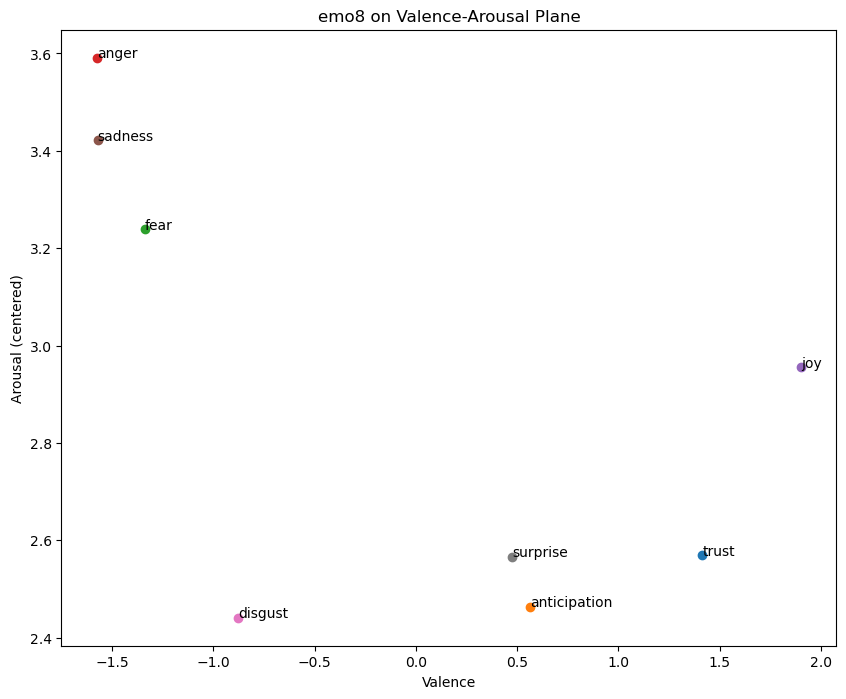

In [85]:
VALENCE_BINS = np.linspace(-3, 3, num=7)
AROUSAL_BINS = np.linspace(0, 6, num=7)

def to_bin(value, bins):
    return int(np.abs(bins - value).argmin())

plt.figure(figsize=(10, 8))

for emo in df['emotion'].unique():
    avg_valence, avg_arousal = emotion_va[emo]
    plt.scatter(avg_valence, avg_arousal, label=emo)
    plt.text(avg_valence, avg_arousal, emo)

plt.xlabel('Valence')
plt.ylabel('Arousal (centered)')
plt.title(f'{global_emotion_label} on Valence-Arousal Plane')
plt.show()

In [86]:
df['valence_bin'] = df['valence'].apply(lambda x: to_bin(x, VALENCE_BINS))
df['arousal_bin'] = df['arousal'].apply(lambda x: to_bin(x, AROUSAL_BINS))

In [87]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity,valence_bin,arousal_bin
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,trust,"BodyLanguage,FacialExpression",0,3,2
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,anticipation,FacialExpression,0,3,2
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,anticipation,BodyLanguage,3,5,2
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,anticipation,"BodyLanguage,FacialExpression",4,4,2
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,fear,ConflictCtxtPerson,0,3,3


In [88]:
# Load category names
scene_categories_path = os.path.join(data_dir, "places365/categories_places365.txt")
with open(scene_categories_path) as f:
    scene_categories = [line.strip().split(' ')[0][3:] for line in f]
    # If there is a / in the category name, replace it with _
    scene_categories = [cat.replace('/', '_') for cat in scene_categories]
print("Length of scene categories:", len(scene_categories))  # Should be 365

Length of scene categories: 365


In [89]:
# get the counts of the labels of emotion
df['emotion'].value_counts()

emotion
joy             7024
anticipation    5901
trust           3549
sadness         2665
anger           2439
fear            2401
disgust         1000
surprise         888
Name: count, dtype: int64

In [90]:
if dataset_size is not None:
    N = dataset_size
else:
    N = len(df)
    
indices = list(range(N))

train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
print("Train indices length:", len(train_indices))
print("Test indices length:", len(test_indices))

Train indices length: 20693
Test indices length: 5174


In [91]:
print(torch.cuda.is_available())
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# let cuDNN pick the fastest kernels for this image size
torch.backends.cudnn.benchmark = True

True


In [92]:
from transformers import AutoImageProcessor, AutoModelForImageClassification, AutoConfig

emotion_transform = AutoImageProcessor.from_pretrained("trpakov/vit-face-expression", use_fast=True)
face_model_base = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")
face_model_base.to(DEVICE)
config = AutoConfig.from_pretrained("trpakov/vit-face-expression")
print(config.id2label)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [93]:
# Delete the last layer so I can use it as a feature extractor
face_model_base = nn.Sequential(*list(face_model_base.children())[:-1])

In [94]:
scene_processor = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load pretrained Places365 ResNet18
scene_model_base = models.resnet18(num_classes=365)
weights_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
checkpoint = torch.hub.load_state_dict_from_url(weights_url, map_location="cpu")
state_dict = {k.replace("module.", ""): v for k, v in checkpoint["state_dict"].items()}
scene_model_base.load_state_dict(state_dict)
scene_model_base.to(DEVICE)
print("Loaded pretrained models")

Loaded pretrained models


In [95]:
scene_model_base = nn.Sequential(*list(scene_model_base.children())[:-1])

In [96]:
df_boxes = pd.read_csv(os.path.join(findingemo_dir, "face_boxes_5.csv"))
# Based on boxes_df we can add the column nr_faces for each original image in df
df['nr_faces'] = df.index.map(df_boxes['index'].value_counts()).fillna(0).astype(int)

In [97]:
class FacesDataset(ImageDataset):
    def __init__(self, indices):
        super().__init__(os.path.join(findingemo_dir, "faces_5"), extension="jpg", transform=emotion_transform)
        self.indices = indices
    
    def __getitem__(self, i):
        if isinstance(i, tuple):
            i = tuple(int(x.value) if isinstance(x, Constant) else x for x in i)
        
        tensor = super().__getitem__("img_{}_face_{}".format(*i))
        return tensor['pixel_values'][0]
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass
    
faces_dataset = FacesDataset(indices)

In [98]:
from abc import ABC, abstractmethod
from pathlib import Path

class ImageDatasetExtension(DPLDataset, ABC):
    def __init__(self, root, extension="png", transform=None):
        super().__init__()
        self.root = Path(root)
        self.transform = transform
        self.extension = extension

    def __getitem__(self, index, extension=None):
        if type(index) is tuple:
            index = index[0]
        if extension is None:
            extension = self.extension
        p = self.root / "{}.{}".format(index, extension)
        with open(p, "rb") as f:
            img = Image.open(f)
            img = img.convert("RGB")
            if self.transform is not None:
                img = self.transform(img)
        return img

In [99]:
class SceneDataset(ImageDatasetExtension):
    def __init__(self, indices):
        super().__init__(os.path.join(findingemo_dir, "scenes_5"), extension="jpg", transform=scene_processor)
        self.indices = indices

    def __getitem__(self, i):
        if isinstance(i, tuple):
            i = tuple(int(x.value) if isinstance(x, Constant) else x for x in i)
        tensor = super().__getitem__(f"scene_{i}")
        return tensor
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass

scenes_dataset = SceneDataset(indices)

# DPL with symbolic knowledge about the data

In [100]:
class DeviceAwareModule(nn.Module):
    """Wrapper that automatically handles device placement for any module"""
    def __init__(self, module):
        super().__init__()
        self.module = module
    
    def forward(self, *args, **kwargs):
        # Move all tensor inputs to model's device
        device = next(self.module.parameters()).device
        
        def to_device(x):
            if isinstance(x, torch.Tensor):
                return x.to(device)
            elif isinstance(x, (list, tuple)):
                return type(x)(to_device(item) for item in x)
            elif isinstance(x, dict):
                return {k: to_device(v) for k, v in x.items()}
            return x
        
        args = to_device(args)
        kwargs = to_device(kwargs)
        output = self.module(*args, **kwargs)

        # Flatten output if it has extra dimensions
        if isinstance(output, torch.Tensor) and output.dim() == 3:
            output = output.squeeze(1)  # Remove the middle dimension [B, 1, C] -> [B, C]
        
        return output
    
    def __getattr__(self, name):
        try:
            return super().__getattr__(name)
        except AttributeError:
            return getattr(self.module, name)

In [101]:
LABEL_TO_ID = {emo: i for i, emo in enumerate(fe_labels)}
print("LABEL_TO_ID:", LABEL_TO_ID)

LABEL_TO_ID: {'anger': 0, 'anticipation': 1, 'disgust': 2, 'fear': 3, 'joy': 4, 'sadness': 5, 'surprise': 6, 'trust': 7}


In [102]:
from deepproblog.utils.confusion_matrix import ConfusionMatrix

from sklearn.metrics import confusion_matrix as sklearn_cm, precision_recall_fscore_support

def evaluate_dpl_with_metrics(model, dataset):
    """Enhanced DPL evaluate function that returns detailed metrics"""
    from deepproblog.utils.confusion_matrix import ConfusionMatrix
    
    confusion_matrix = ConfusionMatrix()
    model.eval()
    
    all_labels = []
    all_preds = []
    
    for i, gt_query in enumerate(tqdm(dataset.to_queries(), desc="Evaluating DPL", leave=False)):
        test_query = gt_query.variable_output()
        answer = model.solve([test_query])[0]
        actual = str(gt_query.output_values()[0])
        
        if len(answer.result) == 0:
            predicted = "no_answer"
        else:
            max_ans = max(answer.result, key=lambda x: answer.result[x])
            p = answer.result[max_ans]
            predicted = str(max_ans.args[gt_query.output_ind[0]])
        
        confusion_matrix.add_item(predicted, actual)
        all_labels.append(actual)
        all_preds.append(predicted)
    
    # Convert emotion labels to indices
    label_to_idx = {emo: i for i, emo in enumerate(fe_labels)}
    y_true = np.array([label_to_idx.get(label, -1) for label in all_labels])
    y_pred = np.array([label_to_idx.get(pred, -1) for pred in all_preds])
    
    # Remove any "no_answer" predictions (-1)
    valid_mask = (y_true >= 0) & (y_pred >= 0)
    y_true = y_true[valid_mask]
    y_pred = y_pred[valid_mask]
    
    # Calculate sklearn confusion matrix
    cm = sklearn_cm(y_true, y_pred, labels=range(len(fe_labels)))
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=range(len(fe_labels)), zero_division=0
    )
    
    # Overall accuracy
    accuracy = confusion_matrix.accuracy()
    result =  {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'dpl_confusion_matrix': confusion_matrix,
        'y_true': y_true,
        'y_pred': y_pred,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support
    }
    print_dpl_detailed_metrics(result, fe_labels)

    model.train()
    return result


def print_dpl_detailed_metrics(results, label_names):
    """Print detailed metrics for DPL results"""
    print(f"\n{'='*70}")
    print(f"Overall Metrics:")
    print(f"{'='*70}")
    print(f"Accuracy: {results['accuracy']:.4f}")
    
    print(f"\n{'='*70}")
    print(f"Per-Class Metrics:")
    print(f"{'='*70}")
    print(f"{'Emotion':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print(f"{'-'*70}")
    
    for i, label in enumerate(label_names):
        print(f"{label:<15} {results['precision'][i]:<12.4f} "
              f"{results['recall'][i]:<12.4f} {results['f1'][i]:<12.4f} "
              f"{int(results['support'][i]):<10}")
    
    # Macro averages
    print(f"{'-'*70}")
    print(f"{'Macro Avg':<15} {results['precision'].mean():<12.4f} "
          f"{results['recall'].mean():<12.4f} {results['f1'].mean():<12.4f} "
          f"{int(results['support'].sum()):<10}")
    
    # Weighted averages
    weights = results['support'] / results['support'].sum()
    weighted_precision = (results['precision'] * weights).sum()
    weighted_recall = (results['recall'] * weights).sum()
    weighted_f1 = (results['f1'] * weights).sum()
    
    print(f"{'Weighted Avg':<15} {weighted_precision:<12.4f} "
          f"{weighted_recall:<12.4f} {weighted_f1:<12.4f} "
          f"{int(results['support'].sum()):<10}")

# Initialize the models, network and final DPL model

In [103]:
class FaceValDataset(TorchDataset):
    def __init__(self, indices, feature_dir = os.path.join(data_dir, "pretrained_backbone", "faces")):
        self.indices = indices
        self.feature_dir = feature_dir

    def __getitem__(self, idx):
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)

        idx = self.indices[idx]    
        valence_bin = df.loc[idx]['valence_bin']
        face_feature_list = []
        for _, box_row in df_boxes[df_boxes['index'] == idx].sort_values('face_rank').iterrows():
            face_rank = int(box_row['face_rank'])
            feature_path = os.path.join(self.feature_dir, f"face_{idx}_{face_rank}.pt")
            face_feature = torch.load(feature_path)
            face_feature_list.append(face_feature)

        if len(face_feature_list) == 0:
            face_avg = torch.zeros(768)

        else:
            face_avg = torch.mean(torch.stack(face_feature_list), dim=0)

        face_avg = face_avg.squeeze()

        return face_avg.to(DEVICE), valence_bin
    
    def __len__(self):
        return len(self.indices)
        

In [104]:
from coral_pytorch.losses import corn_loss

def custom_loss(logits, y, NUM_CLASSES, class_weights=None):
    loss = corn_loss(logits, y, NUM_CLASSES)

    if class_weights is not None:
        weights = class_weights[y]
        loss = (loss * weights).mean()

    else:
        loss = loss.mean()

    return loss

In [105]:
from coral_pytorch.dataset import corn_label_from_logits

def train_epoch(model, loader, optimizer, NUM_CLASSES=None, class_weights=None):
    model.train()
    total_loss = 0
    total_correct_adjacent = 0  # Count predictions within 1 bin
    total_samples = 0
    mae = 0
    mse = 0

    for x, y in tqdm(loader, desc="Training", leave=False):
        x = x.to(DEVICE).float()
        y = y.to(DEVICE).long()  # CE requires long dtype

        optimizer.zero_grad()

        # Forward pass
        logits = model(x)                    # (B, num_bins)
        loss = custom_loss(logits, y, NUM_CLASSES, class_weights=class_weights)
        loss.backward()
        optimizer.step()

        # ---- Metrics ----
        total_loss += loss.item() * x.size(0)
        predicted_labels = corn_label_from_logits(logits).float()

        mae += torch.sum(torch.abs(predicted_labels - y.float()))
        mse += torch.sum((predicted_labels - y.float()) ** 2)

        adjacent_correct = ((predicted_labels - y.float()).abs() <= 1).sum().item()
        total_correct_adjacent += adjacent_correct

        total_samples += x.size(0)

    # Overall metrics
    epoch_loss = total_loss / total_samples
    epoch_acc_adj = total_correct_adjacent / total_samples if total_samples > 0 else 0
    epoch_mae = mae.item() / total_samples
    epoch_mse = mse.item() / total_samples

    return epoch_loss, epoch_acc_adj, epoch_mae, epoch_mse

In [106]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

def evaluate_with_metrics(model, loader, labels, NUM_CLASSES, allow_adjacent=True):
    """Enhanced evaluate function that returns metrics"""
    model.eval()
    total_loss = 0
    total_correct_adjacent = 0  # Count predictions within 1 bin
    total_samples = 0
    mae = torch.tensor(0.0, device=DEVICE)
    mse = torch.tensor(0.0, device=DEVICE)

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for x, y in tqdm(loader, desc="Evaluating", leave=False):
            x = x.to(DEVICE).float()
            y = y.to(DEVICE)

            logits = model(x)
            loss = custom_loss(logits, y, NUM_CLASSES)

            total_loss += loss.item() * x.size(0)
            predicted_labels = corn_label_from_logits(logits).float()

            mae += torch.sum(torch.abs(predicted_labels - y))
            mse += torch.sum((predicted_labels - y)**2)

            all_labels.extend(y.cpu().numpy())
            all_preds.extend(predicted_labels.cpu().numpy())
            
            # Adjacent matches (within 1 bin)
            if allow_adjacent:
                adjacent_correct = ((predicted_labels - y).abs() <= 1).sum().item()
                total_correct_adjacent += adjacent_correct
            
            total_samples += x.size(0)

    # Calculate metrics
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=range(len(labels)), zero_division=0
    )
    
    # Overall metrics
    accuracy_adjacent = total_correct_adjacent / total_samples if allow_adjacent else None
    avg_loss = total_loss / total_samples
    
    return {
        'loss': avg_loss,
        'accuracy_adjacent': accuracy_adjacent,
        'confusion_matrix': cm,
        'y_true': y_true,
        'y_pred': y_pred,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support,
        'mae': mae.item() / total_samples,
        'mse': mse.item() / total_samples
    }


def print_detailed_metrics(results, label_names):
    """Print detailed metrics in a nice format"""
    print(f"\n{'='*70}")
    print(f"Overall Metrics:")
    print(f"{'='*70}")
    print(f"Loss:                {results['loss']:.4f}")
    if results.get('accuracy_adjacent') is not None:
        print(f"Accuracy (±1 bin):   {results['accuracy_adjacent']:.4f}")
    
    print(f"\n{'='*70}")
    print(f"Per-Class Metrics:")
    print(f"{'='*70}")
    print(f"{'Label':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print(f"{'-'*70}")
    
    for i, label in enumerate(label_names):
        print(f"{label:<15} {results['precision'][i]:<12.4f} "
              f"{results['recall'][i]:<12.4f} {results['f1'][i]:<12.4f} "
              f"{int(results['support'][i]):<10}")
    
    # Macro averages
    print(f"{'-'*70}")
    print(f"{'Macro Avg':<15} {results['precision'].mean():<12.4f} "
          f"{results['recall'].mean():<12.4f} {results['f1'].mean():<12.4f} "
          f"{int(results['support'].sum()):<10}")
    
    # Weighted averages
    weights = results['support'] / results['support'].sum()
    weighted_precision = (results['precision'] * weights).sum()
    weighted_recall = (results['recall'] * weights).sum()
    weighted_f1 = (results['f1'] * weights).sum()
    
    print(f"{'Weighted Avg':<15} {weighted_precision:<12.4f} "
          f"{weighted_recall:<12.4f} {weighted_f1:<12.4f} "
          f"{int(results['support'].sum()):<10}")
    
    print(f"{'MAE':<15} {results['mae']:<12.4f}")
    print(f"{'MSE':<15} {results['mse']:<12.4f}")


def plot_confusion_matrix(cm, label_names, normalize=False):
    """Plot confusion matrix with better formatting"""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title = 'Normalized Confusion Matrix'
    else:
        fmt = 'd'
        title = 'Confusion Matrix'
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=label_names, yticklabels=label_names,
                cbar_kws={'label': 'Count' if not normalize else 'Proportion'})
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [107]:
class AdaptiveEarlyStopping:
    """Early stopping with adaptive min_delta based on initial loss scale"""
    def __init__(self, patience=7, min_delta_pct=0.01, mode='min', verbose=True):
        """
        Args:
            patience: How many epochs to wait after last improvement
            min_delta_pct: Minimum % improvement (e.g., 0.01 = 1% improvement needed)
            mode: 'min' for loss, 'max' for accuracy
            verbose: Print messages
        """
        self.patience = patience
        self.min_delta_pct = min_delta_pct
        self.min_delta = None  # Will be set based on first score
        self.mode = mode
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_epoch = 0
        
    def __call__(self, score, epoch):
        # Initialize on first call
        if self.best_score is None:
            self.best_score = score
            self.best_epoch = epoch
            # Set min_delta as percentage of initial score
            self.min_delta = abs(score * self.min_delta_pct)
            if self.verbose:
                print(f"Initial score: {score:.4f}")
                print(f"Min delta set to: {self.min_delta:.6f} ({self.min_delta_pct*100:.1f}% of score)")
            return False
        
        # Check if score improved
        if self.mode == 'min':
            improved = score < (self.best_score - self.min_delta)
        else:
            improved = score > (self.best_score + self.min_delta)
        
        if improved:
            improvement = abs(score - self.best_score)
            improvement_pct = (improvement / self.best_score) * 100
            if self.verbose:
                print(f"Score improved: {self.best_score:.4f} → {score:.4f} (Δ={improvement:.4f}, {improvement_pct:.2f}%)")
            self.best_score = score
            self.best_epoch = epoch
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"No improvement for {self.counter}/{self.patience} epochs (best: {self.best_score:.4f} @ epoch {self.best_epoch})")
            
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f"\n{'='*70}")
                    print(f"Early stopping triggered!")
                    print(f"Best score: {self.best_score:.4f} at epoch {self.best_epoch}")
                    print(f"{'='*70}\n")
                return True
        
        return False

In [108]:
valence_bin_labels = [f"V{i}" for i in range(len(VALENCE_BINS))]
arousal_bin_labels = [f"A{i}" for i in range(len(AROUSAL_BINS))]

In [109]:
# Show how many samples per valence bin in the training set
train_valence_counts = df.loc[train_indices]['valence_bin'].value_counts().sort_index()
print("Training set valence bin counts:")
print(train_valence_counts)

# Show how many samples per arousal bin in the training set
train_arousal_counts = df.loc[train_indices]['arousal_bin'].value_counts().sort_index()
print("Training set arousal bin counts:")
print(train_arousal_counts)

Training set valence bin counts:
valence_bin
0    1491
1    2446
2    2872
3    2735
4    4575
5    4122
6    2452
Name: count, dtype: int64
Training set arousal bin counts:
arousal_bin
0    1123
1    3676
2    4305
3    4098
4    3609
5    2433
6    1449
Name: count, dtype: int64


# Face Valence Predictor

In [110]:
from deepproblog.utils.standard_networks import MLP
face_val_model_raw = MLP(
    768,        # input size
    256, 64,   # hidden layers
    len(VALENCE_BINS) - 1,       # output size (valence bins), -1 for the corn_loss   
    activation=nn.ReLU,
    softmax=False,   
    batch=True
)
face_val_model = DeviceAwareModule(face_val_model_raw).to(DEVICE)

In [111]:
# from torch.utils.data import WeightedRandomSampler

# MAX_EPOCHS = 100
# PATIENCE = 5

face_val_optimizer = torch.optim.AdamW(
    face_val_model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

# # Calculate weights
# train_labels = [df.loc[train_indices[i], 'valence_bin'] for i in range(len(train_indices))]
# class_counts = np.bincount(train_labels)
# class_weights_np = (1.0 / (class_counts + 1e-9))**1.5
# class_weights_np = class_weights_np / class_weights_np.sum()
# class_weights = torch.tensor(class_weights_np, device=DEVICE)

# face_val_train_dataset = FaceValDataset(train_indices)
face_val_test_dataset = FaceValDataset(test_indices)

# # Oversampling
# sample_weights = [class_weights_np[label] for label in train_labels]
# sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# face_val_train_loader = DataLoader(
#     face_val_train_dataset, 
#     batch_size=batch_size, 
#     sampler=sampler
# )

face_val_test_loader = DataLoader(face_val_test_dataset, batch_size=batch_size, shuffle=False)

# early_stopping = AdaptiveEarlyStopping(
#     patience=PATIENCE,
#     min_delta_pct=0.01,
#     mode='min',
#     verbose=True
# )

# # Track best model
# best_model_state = None
# best_val_mse = float('inf')

# for epoch in range(MAX_EPOCHS):
#     print(f"\nEpoch {epoch + 1}/{MAX_EPOCHS}")
    
#     # Train
#     train_loss, train_acc_adj, train_mae, train_mse = train_epoch(
#         face_val_model, 
#         face_val_train_loader, 
#         face_val_optimizer, 
#         NUM_CLASSES=len(VALENCE_BINS),
#         class_weights=class_weights
#     )
#     print(f"Train Loss: {train_loss:.4f}, Train Adjacent Accuracy: {train_acc_adj:.4f}, Train MAE: {train_mae:.4f}, Train MSE: {train_mse:.4f}")
    
#     if (epoch + 1) % 3 == 0:
#         # Evaluate
#         results = evaluate_with_metrics(
#             face_val_model, 
#             face_val_test_loader, 
#             valence_bin_labels, 
#             NUM_CLASSES=len(VALENCE_BINS)
#         )
    
#         val_mse = results['mse']

#         # Save best model based on validation MSE
#         if val_mse < best_val_mse:
#             best_val_mse = val_mse
#             best_model_state = face_val_model.state_dict().copy()
#             print(f"New best model! (MSE: {best_val_mse:.4f})")
        
#         if early_stopping(val_mse, epoch + 1):
#             print("Early stopping triggered. Stopping training.")
#             break

#         print_detailed_metrics(results, valence_bin_labels)
#         # Plot confusion matrix
#         plot_confusion_matrix(results['confusion_matrix'], valence_bin_labels, normalize=True)


# # Load and save best model
# print(f"\nLoading best model (Val MSE: {best_val_mse:.4f})")
# face_val_model.load_state_dict(best_model_state)
# torch.save(face_val_model.state_dict(), os.path.join(model_dir, "face_val_model.pth"))

In [112]:
# Load the best model for evaluation
face_val_model.load_state_dict(torch.load(os.path.join(model_dir, "face_val_model.pth")))

# final_results = evaluate_with_metrics(
#     face_val_model,
#     face_val_test_loader,
#     valence_bin_labels,
#     NUM_CLASSES=len(VALENCE_BINS)
# )   
# print_detailed_metrics(final_results, valence_bin_labels)
# plot_confusion_matrix(final_results['confusion_matrix'], valence_bin_labels, normalize=True)

<All keys matched successfully>

# Face Arousal Predictor

In [113]:
class FaceAroDataset(TorchDataset):
    def __init__(self, indices, feature_dir = os.path.join(data_dir, "pretrained_backbone", "faces")):
        self.indices = indices
        self.feature_dir = feature_dir

    def __getitem__(self, idx):
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)

        idx = self.indices[idx]    
        arousal_bin = df.loc[idx]['arousal_bin']
        face_feature_list = []
        for _, box_row in df_boxes[df_boxes['index'] == idx].sort_values('face_rank').iterrows():
            face_rank = int(box_row['face_rank'])
            feature_path = os.path.join(self.feature_dir, f"face_{idx}_{face_rank}.pt")
            face_feature = torch.load(feature_path)
            face_feature_list.append(face_feature)

        if len(face_feature_list) == 0:
            face_avg = torch.zeros(768)

        else:
            face_avg = torch.mean(torch.stack(face_feature_list), dim=0)

        face_avg = face_avg.squeeze()

        return face_avg.to(DEVICE), arousal_bin
    
    def __len__(self):
        return len(self.indices)

In [114]:
face_aro_model_raw = MLP(
    768,        # input size
    256, 64,   # hidden layers
    len(AROUSAL_BINS) - 1,       # output size (arousal bins)   
    activation=nn.ReLU,
    softmax=False,   
    batch=True
)
face_aro_model = DeviceAwareModule(face_aro_model_raw).to(DEVICE)

In [115]:
# from torch.utils.data import WeightedRandomSampler

# MAX_EPOCHS = 100
# PATIENCE = 5

face_aro_optimizer = torch.optim.AdamW(
    face_aro_model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

# # Calculate weights
# train_labels = [df.loc[train_indices[i], 'arousal_bin'] for i in range(len(train_indices))]
# class_counts = np.bincount(train_labels)
# class_weights_np = (1.0 / (class_counts + 1e-9))**1.5
# class_weights_np = class_weights_np / class_weights_np.sum()
# class_weights = torch.tensor(class_weights_np, device=DEVICE)

# face_aro_train_dataset = FaceAroDataset(train_indices)
face_aro_test_dataset = FaceAroDataset(test_indices)

# # Oversampling
# sample_weights = [class_weights_np[label] for label in train_labels]
# sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# face_aro_train_loader = DataLoader(
#     face_aro_train_dataset, 
#     batch_size=batch_size, 
#     sampler=sampler
# )

face_aro_test_loader = DataLoader(face_aro_test_dataset, batch_size=batch_size, shuffle=False)

# early_stopping = AdaptiveEarlyStopping(
#     patience=PATIENCE,
#     min_delta_pct=0.01,
#     mode='min',
#     verbose=True
# )

# # Track best model
# best_model_state = None
# best_aro_mse = float('inf')

# for epoch in range(MAX_EPOCHS):
#     print(f"\nEpoch {epoch + 1}/{MAX_EPOCHS}")
    
#     # Train
#     train_loss, train_acc_adj, train_mae, train_mse = train_epoch(
#         face_aro_model, 
#         face_aro_train_loader, 
#         face_aro_optimizer, 
#         NUM_CLASSES=len(AROUSAL_BINS),
#         class_weights=class_weights
#     )
#     print(f"Train Loss: {train_loss:.4f}, Train Adjacent Accuracy: {train_acc_adj:.4f}, Train MAE: {train_mae:.4f}, Train MSE: {train_mse:.4f}")
    
#     if (epoch + 1) % 3 == 0:
#         # Evaluate
#         results = evaluate_with_metrics(
#             face_aro_model, 
#             face_aro_test_loader, 
#             arousal_bin_labels, 
#             NUM_CLASSES=len(AROUSAL_BINS)
#         )
    
#         aro_mse = results['mse']

#         # Save best model based on validation MSE
#         if aro_mse < best_aro_mse:
#             best_aro_mse = aro_mse
#             best_model_state = face_aro_model.state_dict().copy()
#             print(f"New best model! (MSE: {best_aro_mse:.4f})")
        
#         if early_stopping(aro_mse, epoch + 1):
#             print("Early stopping triggered. Stopping training.")
#             break

#         print_detailed_metrics(results, arousal_bin_labels)
#         # Plot confusion matrix
#         plot_confusion_matrix(results['confusion_matrix'], arousal_bin_labels, normalize=True)


# # Load and save best model
# print(f"\nLoading best model (Val MSE: {best_aro_mse:.4f})")
# face_aro_model.load_state_dict(best_model_state)
# torch.save(face_aro_model.state_dict(), os.path.join(model_dir, "face_aro_model.pth"))

In [116]:
face_aro_model.load_state_dict(torch.load(os.path.join(model_dir, "face_aro_model.pth")))

# final_results = evaluate_with_metrics(
#     face_aro_model,
#     face_aro_test_loader,
#     arousal_bin_labels,
#     NUM_CLASSES=len(AROUSAL_BINS)
# )

# print_detailed_metrics(final_results, arousal_bin_labels)
# plot_confusion_matrix(final_results['confusion_matrix'], arousal_bin_labels, normalize=True)

<All keys matched successfully>

In [117]:
class SceneValDataset(TorchDataset):
    def __init__(self, indices, feature_dir = os.path.join(data_dir, "pretrained_backbone", "scenes")):
        self.indices = indices
        self.feature_dir = feature_dir

    def __getitem__(self, idx):
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)

        idx = self.indices[idx]    
        valence_bin = df.loc[idx]['valence_bin']
        feature_path = os.path.join(self.feature_dir, f"scene_{idx}.pt")
        scene_feature = torch.load(feature_path)
        scene_feature = scene_feature.squeeze()

        return scene_feature.to(DEVICE), valence_bin
    
    def __len__(self):
        return len(self.indices)

In [118]:
scene_val_model_raw = MLP(
    512,        # input size
    256, 64,   # hidden layers
    len(VALENCE_BINS) - 1,       # output size (valence bins)   
    activation=nn.ReLU,
    softmax=False,   
    batch=True
)
scene_val_model = DeviceAwareModule(scene_val_model_raw).to(DEVICE)

In [119]:
# MAX_EPOCHS = 100
# PATIENCE = 5

scene_val_optimizer = torch.optim.AdamW(
    scene_val_model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

# # Calculate weights
# train_labels = [df.loc[train_indices[i], 'valence_bin'] for i in range(len(train_indices))]
# class_counts = np.bincount(train_labels)
# class_weights_np = (1.0 / (class_counts + 1e-9))**1.5
# class_weights_np = class_weights_np / class_weights_np.sum()
# class_weights = torch.tensor(class_weights_np, device=DEVICE)

# scene_val_train_dataset = SceneValDataset(train_indices)
scene_val_test_dataset = SceneValDataset(test_indices)

# # Oversampling
# sample_weights = [class_weights_np[label] for label in train_labels]
# sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# scene_val_train_loader = DataLoader(
#     scene_val_train_dataset, 
#     batch_size=batch_size, 
#     sampler=sampler
# )

scene_val_test_loader = DataLoader(scene_val_test_dataset, batch_size=batch_size, shuffle=False)

# early_stopping = AdaptiveEarlyStopping(
#     patience=PATIENCE,
#     min_delta_pct=0.01,
#     mode='min',
#     verbose=True
# )

# # Track best model
# best_model_state = None
# best_val_mse = float('inf')

# for epoch in range(MAX_EPOCHS):
#     print(f"\nEpoch {epoch + 1}/{MAX_EPOCHS}")
    
#     # Train
#     train_loss, train_acc_adj, train_mae, train_mse = train_epoch(
#         scene_val_model, 
#         scene_val_train_loader, 
#         scene_val_optimizer, 
#         NUM_CLASSES=len(VALENCE_BINS),
#         class_weights=class_weights
#     )
#     print(f"Train Loss: {train_loss:.4f}, Train Adjacent Accuracy: {train_acc_adj:.4f}, Train MAE: {train_mae:.4f}, Train MSE: {train_mse:.4f}")
    
#     if (epoch + 1) % 3 == 0:
#         # Evaluate
#         results = evaluate_with_metrics(
#             scene_val_model, 
#             scene_val_test_loader, 
#             valence_bin_labels, 
#             NUM_CLASSES=len(VALENCE_BINS)
#         )
    
#         val_mse = results['mse']

#         # Save best model based on validation MSE
#         if val_mse < best_val_mse:
#             best_val_mse = val_mse
#             best_model_state = scene_val_model.state_dict().copy()
#             print(f"New best model! (MSE: {best_val_mse:.4f})")
        
#         if early_stopping(val_mse, epoch + 1):
#             print("Early stopping triggered. Stopping training.")
#             break

#         print_detailed_metrics(results, valence_bin_labels)
#         # Plot confusion matrix
#         plot_confusion_matrix(results['confusion_matrix'], valence_bin_labels, normalize=True)


# # Load and save best model
# print(f"\nLoading best model (Val MSE: {best_val_mse:.4f})")
# scene_val_model.load_state_dict(best_model_state)
# torch.save(scene_val_model.state_dict(), os.path.join(model_dir, "scene_val_model.pth"))

In [120]:
scene_val_model.load_state_dict(torch.load(os.path.join(model_dir, "scene_val_model.pth")))

# final_results = evaluate_with_metrics(
#     scene_val_model,
#     scene_val_test_loader,
#     valence_bin_labels, 
#     NUM_CLASSES=len(VALENCE_BINS)
# )
# print_detailed_metrics(final_results, valence_bin_labels)
# plot_confusion_matrix(final_results['confusion_matrix'], valence_bin_labels, normalize=True)

<All keys matched successfully>

In [121]:
class SceneAroDataset(TorchDataset):
    def __init__(self, indices, feature_dir = os.path.join(data_dir, "pretrained_backbone", "scenes")):
        self.indices = indices
        self.feature_dir = feature_dir

    def __getitem__(self, idx):
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)

        idx = self.indices[idx]    
        arousal_bin = df.loc[idx]['arousal_bin']
        feature_path = os.path.join(self.feature_dir, f"scene_{idx}.pt")
        scene_feature = torch.load(feature_path)
        scene_feature = scene_feature.squeeze()

        return scene_feature.to(DEVICE), arousal_bin
    
    def __len__(self):
        return len(self.indices)

In [122]:
scene_aro_model_raw = MLP(
    512,        # input size
    256, 64,   # hidden layers
    len(AROUSAL_BINS) - 1,       # output size (arousal bins)   
    activation=nn.ReLU,
    softmax=False,   
    batch=True
)
scene_aro_model = DeviceAwareModule(scene_aro_model_raw).to(DEVICE)

In [123]:
# from torch.utils.data import WeightedRandomSampler

# MAX_EPOCHS = 100
# PATIENCE = 5

scene_aro_optimizer = torch.optim.AdamW(
    scene_aro_model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

# # Calculate weights
# train_labels = [df.loc[train_indices[i], 'arousal_bin'] for i in range(len(train_indices))]
# class_counts = np.bincount(train_labels)
# class_weights_np = (1.0 / (class_counts + 1e-9))**1.5
# class_weights_np = class_weights_np / class_weights_np.sum()
# class_weights = torch.tensor(class_weights_np, device=DEVICE)

# scene_aro_train_dataset = SceneAroDataset(train_indices)
scene_aro_test_dataset = SceneAroDataset(test_indices)

# # Oversampling
# sample_weights = [class_weights_np[label] for label in train_labels]
# sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# scene_aro_train_loader = DataLoader(
#     scene_aro_train_dataset, 
#     batch_size=batch_size, 
#     sampler=sampler
# )

scene_aro_test_loader = DataLoader(scene_aro_test_dataset, batch_size=batch_size, shuffle=False)

# early_stopping = AdaptiveEarlyStopping(
#     patience=PATIENCE,
#     min_delta_pct=0.01,
#     mode='min',
#     verbose=True
# )

# # Track best model
# best_model_state = None
# best_val_mse = float('inf')

# for epoch in range(MAX_EPOCHS):
#     print(f"\nEpoch {epoch + 1}/{MAX_EPOCHS}")
    
#     # Train
#     train_loss, train_acc_adj, train_mae, train_mse = train_epoch(
#         scene_aro_model, 
#         scene_aro_train_loader, 
#         scene_aro_optimizer, 
#         NUM_CLASSES=len(AROUSAL_BINS),
#         class_weights=class_weights
#     )
#     print(f"Train Loss: {train_loss:.4f}, Train Adjacent Accuracy: {train_acc_adj:.4f}, Train MAE: {train_mae:.4f}, Train MSE: {train_mse:.4f}")
    
#     if (epoch + 1) % 3 == 0:
#         # Evaluate
#         results = evaluate_with_metrics(
#             scene_aro_model, 
#             scene_aro_test_loader, 
#             arousal_bin_labels, 
#             NUM_CLASSES=len(AROUSAL_BINS)
#         )
    
#         aro_mse = results['mse']

#         # Save best model based on validation MSE
#         if aro_mse < best_val_mse:
#             best_val_mse = aro_mse
#             best_model_state = scene_aro_model.state_dict().copy()
#             print(f"New best model! (MSE: {best_val_mse:.4f})")
        
#         if early_stopping(aro_mse, epoch + 1):
#             print("Early stopping triggered. Stopping training.")
#             break

#         print_detailed_metrics(results, arousal_bin_labels)
#         # Plot confusion matrix
#         plot_confusion_matrix(results['confusion_matrix'], arousal_bin_labels, normalize=True)


# # Load and save best model
# print(f"\nLoading best model (Val MSE: {best_val_mse:.4f})")
# scene_aro_model.load_state_dict(best_model_state)
# torch.save(scene_aro_model.state_dict(), os.path.join(model_dir, "scene_aro_model.pth"))

In [124]:
scene_aro_model.load_state_dict(torch.load(os.path.join(model_dir, "scene_aro_model.pth")))
# final_results = evaluate_with_metrics(
#     scene_aro_model,
#     scene_aro_test_loader,
#     arousal_bin_labels,
#     NUM_CLASSES=len(AROUSAL_BINS)
# )
# print_detailed_metrics(final_results, arousal_bin_labels)
# plot_confusion_matrix(final_results['confusion_matrix'], arousal_bin_labels, normalize=True)

<All keys matched successfully>

In [125]:
class FaceFeatureDataset(DPLDataset):
    def __init__(self, indices, feature_dir):
        self.indices = indices
        self.feature_dir = feature_dir

    def __getitem__(self, idx):
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)

        # Load all face backbone features (768 each), average; if none, use neutral
        face_rows = df_boxes[df_boxes['index'] == idx].sort_values('face_rank')
        face_features_list = []
        for _, box_row in face_rows.iterrows():
            face_rank = int(box_row['face_rank'])
            face_prediction_file = os.path.join(self.feature_dir, "faces", f"face_{idx}_{face_rank}.pt")
            face_features = torch.load(face_prediction_file, map_location="cpu")  # 
            face_features_list.append(face_features)

        if len(face_features_list) == 0:
            face_avg = torch.zeros(768, dtype=torch.float32)
        else:
            face_avg = torch.stack(face_features_list).mean(dim=0)  # (768,)

        return face_avg
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass

face_features_train = FaceFeatureDataset(train_indices, os.path.join(data_dir, "pretrained_backbone"))
face_features_test = FaceFeatureDataset(test_indices, os.path.join(data_dir, "pretrained_backbone"))        

In [126]:
class SceneFeatureDataset(DPLDataset):
    def __init__(self, indices, feature_dir):
        self.indices = indices
        self.feature_dir = feature_dir

    def __getitem__(self, idx):
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)

        scene_prediction_file = os.path.join(self.feature_dir, "scenes", f"scene_{idx}.pt")
        scene_features = torch.load(scene_prediction_file, map_location="cpu")  # (512,)

        return scene_features
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass

scene_features_train = SceneFeatureDataset(train_indices, os.path.join(data_dir, "pretrained_backbone"))
scene_features_test = SceneFeatureDataset(test_indices, os.path.join(data_dir, "pretrained_backbone"))

In [127]:
emotion_centroids = {}
# For every emotion, count +3 for the valence value
for emo, (valence, arousal) in emotion_va.items():
    valence_centered = valence + 3
    emotion_centroids[emo] = (valence_centered, arousal)

In [128]:
emotion_centroids

{'anger': (1.4243542435424354, 3.5912259122591226),
 'anticipation': (3.562447042874089, 2.463650228774784),
 'disgust': (2.124, 2.441),
 'fear': (1.6609745939192004, 3.239067055393586),
 'joy': (4.902050113895216, 2.9552961275626424),
 'sadness': (1.4292682926829268, 3.4221388367729833),
 'surprise': (3.4763513513513513, 2.5664414414414414),
 'trust': (4.414201183431953, 2.5694561848408)}

In [129]:
class VA2Emotion(nn.Module):
    def __init__(self, centroids):
        super().__init__()
        self.centroids = nn.Parameter(torch.tensor(centroids, dtype=torch.float32), requires_grad=False)  # shape (8, 2)
        self.log_alpha = nn.Parameter(torch.tensor(0.0))  # learnable temperature

    def forward(self, valence, arousal):
        # Convert inputs to tensors if they're lists/scalars
        if not isinstance(valence, torch.Tensor):
            valence = torch.tensor(valence, dtype=torch.float32)
        if not isinstance(arousal, torch.Tensor):
            arousal = torch.tensor(arousal, dtype=torch.float32)
        
        # Move to correct device
        device = self.centroids.device
        valence = valence.to(device)
        arousal = arousal.to(device)
        
        # Ensure they are at least 1D
        if valence.dim() == 0:
            valence = valence.unsqueeze(0)
        if arousal.dim() == 0:
            arousal = arousal.unsqueeze(0)
            
        # Ensure they are 2D for broadcasting
        if valence.dim() == 1:
            valence = valence.unsqueeze(1)  # (batch, 1)
        if arousal.dim() == 1:
            arousal = arousal.unsqueeze(1)  # (batch, 1)
        
        V = valence  # (batch, 1)
        A = arousal  # (batch, 1)

        C = self.centroids  # shape (8, 2)
        # compute squared distances -> shape (batch, 8)
        d2 = (V - C[:, 0])**2 + (A - C[:, 1])**2
        
        # softmax over negative distances
        alpha = torch.exp(self.log_alpha)
        probs = F.softmax(-alpha * d2, dim=1)
        return probs

In [130]:
class CORNWrapper(nn.Module):
    """
    A PyTorch module to wrap a base model trained with CORN loss, 
    converting its K-1 logit outputs into K normalized class probabilities.
    """
    def __init__(self, base_model, num_classes):
        super().__init__()
        self.base_model = base_model
        self.num_classes = num_classes
        self.num_thresholds = num_classes - 1

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # 1. Base Model Output: Get K-1 logits
        # logits.shape will be (B, K-1)
        logits = self.base_model(x) 
        
        # 2. Conditional Probabilities (Threshold Probs)
        # P(y > r_k | y > r_{k-1}) for k=1 to K-1
        # sigmoid_probs.shape will be (B, K-1)
        conditional_probs = torch.sigmoid(logits) 
        
        # 3. Cumulative Probabilities (P(y > r_k))
        # P_gt.shape will be (B, K-1)
        # P_gt[:, k] = P(y > r_k)
        p_gt = torch.cumprod(conditional_probs, dim=1)
        
        B = logits.size(0)
        
        # Initialize the final K-class probability tensor
        # probs.shape will be (B, K)
        probs = torch.zeros(B, self.num_classes, device=logits.device)

        # The cumulative probability array needs an initial P(y > r_0) = 1.0 
        # for proper subtraction. We use a column of ones for the batch.
        p_gt_r0 = torch.ones(B, 1, device=logits.device)
        
        # This tensor now represents: [P(y > r_0), P(y > r_1), ..., P(y > r_{K-1})]
        # cum_prob_full.shape is (B, K)
        cum_prob_full = torch.cat([p_gt_r0, p_gt], dim=1)

        # 4. Calculate Unconditional Class Probabilities P(y = j)
        # P(y = j) = P(y > r_{j-1}) - P(y > r_j)
        
        # Class 0: P(y = 0) = P(y > r_0) - P(y > r_1)
        # Class 0 uses cum_prob_full[:, 0] and cum_prob_full[:, 1]
        probs[:, 0] = cum_prob_full[:, 0] - cum_prob_full[:, 1] 
        
        # Classes 1 through K-2: P(y = k) = P(y > r_k) - P(y > r_{k+1})
        for k in range(1, self.num_classes - 1):
            probs[:, k] = cum_prob_full[:, k] - cum_prob_full[:, k + 1]

        # Class K-1 (The highest class): P(y = K-1) = P(y > r_{K-1})
        # This is the last element of the cumulative probability array.
        probs[:, -1] = cum_prob_full[:, -1]
        
        # Note: The clamp and sum normalization steps might be unnecessary 
        # if the input logits are stable, as the conversion inherently results 
        # in probabilities that sum to 1 and are non-negative.
        # However, keeping the clamp is a safe guard against numerical issues.
        probs = torch.clamp(probs, min=0)
        probs = probs / probs.sum(dim=1, keepdim=True)
        
        return probs

In [131]:
face_val_model_dpl = CORNWrapper(face_val_model, num_classes=len(VALENCE_BINS))
scene_val_model_dpl = CORNWrapper(scene_val_model, num_classes=len(VALENCE_BINS))
face_aro_model_dpl = CORNWrapper(face_aro_model, num_classes=len(AROUSAL_BINS))
scene_aro_model_dpl = CORNWrapper(scene_aro_model, num_classes=len(AROUSAL_BINS))

In [132]:
face_val_network = Network(face_val_model_dpl, "face_val_model", batching=True)
scene_val_network = Network(scene_val_model_dpl, "scene_val_model", batching=True)
face_aro_network = Network(face_aro_model_dpl, "face_aro_model", batching=True)
scene_aro_network = Network(scene_aro_model_dpl, "scene_aro_model", batching=True)

va2emotion_model_raw = VA2Emotion([list(emotion_centroids.values())])
va2emotion_model = DeviceAwareModule(va2emotion_model_raw).to(DEVICE)

va2emotion_network = Network(va2emotion_model, "va2emotion_model", batching=True)
va2emotion_network.optimizer = torch.optim.AdamW(
    va2emotion_model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

In [133]:
face_val_network.optimizer = face_val_optimizer
scene_val_network.optimizer = scene_val_optimizer
face_aro_network.optimizer = face_aro_optimizer
scene_aro_network.optimizer = scene_aro_optimizer

In [134]:
# # Enable gradients for all parameters
# for network in [face_val_network, scene_val_network, face_aro_network, scene_aro_network, va2emotion_network]:
#     for param in network.network_module.parameters():
#         param.requires_grad = True

In [135]:
from deepproblog.engines import ApproximateEngine
heuristic2 = ApproximateEngine.geometric_mean

model = Model(os.path.join(prolog_dir, "model_6.pl"), [face_val_network, face_aro_network, scene_val_network, scene_aro_network, va2emotion_network])
# model.set_engine(ExactEngine(model))
model.set_engine(ApproximateEngine(model, 10, heuristic2))

# model.register_foreign(closest_emotion, "closest_emotion", 2, 1)

model.add_tensor_source("face_features_train", face_features_train)
model.add_tensor_source("scene_features_train", scene_features_train)
model.add_tensor_source("face_features_test", face_features_test)
model.add_tensor_source("scene_features_test", scene_features_test)

model.optimizer = SGD(model, 5e-2)

In [136]:
class FEQUeryDataset(DPLDataset):
    def __init__(self, indices, dataset_name):
        self.indices = indices
        self.dataset_name = dataset_name

    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, index):
        pass

    def to_query(self, idx):
        idx = self.indices[idx]
        label_str = df.iloc[idx]['emotion']

        return Query(
            Term("final_emotion",
                Term("tensor", Term(f"face_features_{self.dataset_name}", Constant(idx))),
                Term("tensor", Term(f"scene_features_{self.dataset_name}", Constant(idx))),
                Term(label_str)
                )
        )
    
train_dataset = FEQUeryDataset(train_indices, "train")
test_dataset = FEQUeryDataset(test_indices, "test")

In [137]:
train_dataset.to_query(0)

(1.0::final_emotion(tensor(face_features_train(2405)),tensor(scene_features_train(2405)),joy), {})

In [138]:
def debug_query(model, pred_name, *args, substitution=None):
    """Helper to test intermediate predicates"""
    query = Query(Term(pred_name, *args), substitution=substitution)
    print(f"\n{'='*60}")
    print(f"Testing: {pred_name}")
    print(f"{'='*60}")
    model.eval()
    results = model.solve([query])
    result = results[0].result
    
    # Print probabilities nicely
    for key, prob in sorted(result.items(), key=lambda x: -x[1]):
        print(f"  {key}: {prob:.4f}")
    
    return result

In [139]:
def show_image(dataframe, index):
    img_path = os.path.join(findingemo_dir, dataframe.loc[index, 'image_path'])
    print(dataframe.loc[index])
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

image_path     Run_2/Somber students shop/urn-publicid-ap-org...
tags                                                   Undefined
age                                         Youth,Adults,Seniors
valence                                                       -2
arousal                                                        4
emotion                                                  sadness
dec_factors                                         BodyLanguage
ambiguity                                                      3
valence_bin                                                    1
arousal_bin                                                    4
nr_faces                                                       5
Name: 11526, dtype: object


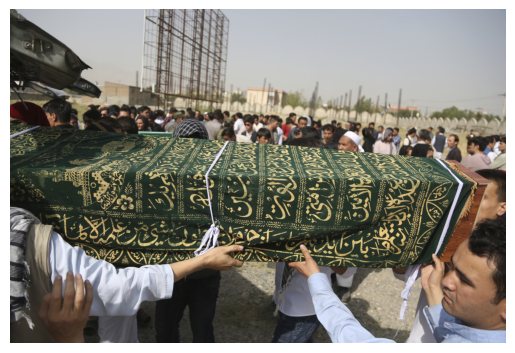


Testing: test_face_val_bin
  test_face_val_bin(tensor(face_features_test(11526)),0): 0.6148
  test_face_val_bin(tensor(face_features_test(11526)),1): 0.2442
  test_face_val_bin(tensor(face_features_test(11526)),2): 0.0810
  test_face_val_bin(tensor(face_features_test(11526)),3): 0.0365
  test_face_val_bin(tensor(face_features_test(11526)),4): 0.0143
  test_face_val_bin(tensor(face_features_test(11526)),5): 0.0060
  test_face_val_bin(tensor(face_features_test(11526)),6): 0.0032

Testing: test_face_aro_bin
  test_face_aro_bin(tensor(face_features_test(11526)),0): 0.2581
  test_face_aro_bin(tensor(face_features_test(11526)),5): 0.1659
  test_face_aro_bin(tensor(face_features_test(11526)),1): 0.1413
  test_face_aro_bin(tensor(face_features_test(11526)),3): 0.1324
  test_face_aro_bin(tensor(face_features_test(11526)),4): 0.1250
  test_face_aro_bin(tensor(face_features_test(11526)),2): 0.1249
  test_face_aro_bin(tensor(face_features_test(11526)),6): 0.0523

Testing: test_scene_val_bin
  tes

In [140]:
test_idx = np.random.choice(test_indices)

show_image(df, test_idx)

debug_query(model,
            "test_face_val_bin",
            Term("tensor", Term("face_features_test", Constant(test_idx))),
            Var("VBin"))

debug_query(model,
            "test_face_aro_bin",
            Term("tensor", Term("face_features_test", Constant(test_idx))),
            Var("ABin"))

debug_query(model,
            "test_scene_val_bin",
            Term("tensor", Term("scene_features_test", Constant(test_idx))),
            Var("VBin"))

debug_query(model,
            "test_scene_aro_bin",
            Term("tensor", Term("scene_features_test", Constant(test_idx))),
            Var("ABin"))

debug_query(model,
            "test_combine_val_bin",
            Term("tensor", Term("face_features_test", Constant(test_idx))),
            Term("tensor", Term("scene_features_test", Constant(test_idx))),
            Var("CV"))

debug_query(model,
            "test_combine_aro_bin",
            Term("tensor", Term("face_features_test", Constant(test_idx))),
            Term("tensor", Term("scene_features_test", Constant(test_idx))),
            Var("CA"))

debug_query(model,
            "final_emotion",
            Term("tensor", Term("face_features_test", Constant(test_idx))),
            Term("tensor", Term("scene_features_test", Constant(test_idx))),
            Var("Emotion"))

print("Debugging queries done.")

In [141]:
train_loader = DPLDataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [143]:
import torch
import numpy as np

# Build distance matrix (do this once before training)
def build_distance_matrix(emotion_centroids, fe_labels, device):
    """Build and normalize distance matrix between emotions"""
    n_emotions = len(fe_labels)
    distances = np.zeros((n_emotions, n_emotions))
    
    for i, emo_i in enumerate(fe_labels):
        for j, emo_j in enumerate(fe_labels):
            v_i, a_i = emotion_centroids[emo_i]
            v_j, a_j = emotion_centroids[emo_j]
            
            dist = np.sqrt((v_i - v_j)**2 + (a_i - a_j)**2)
            distances[i, j] = dist
    
    # Normalize to [0, 1]
    max_dist = distances.max()
    if max_dist > 0:
        distances = distances / max_dist
    
    return torch.tensor(distances, dtype=torch.float32, device=device)


# Create distance matrix
distance_matrix = build_distance_matrix(emotion_centroids, fe_labels, DEVICE)

# Prepare loss function kwargs
loss_kwargs = {
    'emotion_centroids': emotion_centroids,
    'fe_labels': fe_labels,
    'distance_matrix': distance_matrix,
    'scale': 1  # Adjust this: 0.1 = weak penalty, 1.0 = strong penalty, 2.0+ = very strong
}

# Train with custom loss
train_obj = train_model(
    model,
    train_loader,
    5,
    batch_size=batch_size,
    log_iter=log_iter,
    test_iter=20 * log_iter,
    # loss_function_name="emotion_distance_loss",  # ← Your custom loss!
    # loss_kwargs=loss_kwargs,  # Pass your parameters
    test=lambda x: [
        ("test_accuracy", evaluate_dpl_with_metrics(model, test_dataset)['accuracy'])
    ],
    infoloss=0.5,
    initial_test = False
)

Training  for 5 epoch(s)
Epoch 1
Iteration:  2 	s:16.2319 	Average Loss:  2.211322348564863
Iteration:  4 	s:39.8746 	Average Loss:  3.814377449452877
Iteration:  6 	s:36.9815 	Average Loss:  3.394753336906433
Iteration:  8 	s:41.5554 	Average Loss:  3.6452469676733017
Iteration:  10 	s:39.4921 	Average Loss:  3.0416829362511635
Iteration:  12 	s:35.5939 	Average Loss:  2.9472943730652332
Iteration:  14 	s:37.3704 	Average Loss:  2.3422310389578342
Iteration:  16 	s:37.7523 	Average Loss:  2.373517084866762
Iteration:  18 	s:36.1667 	Average Loss:  1.5708300583064556
Iteration:  20 	s:37.5487 	Average Loss:  1.4299430008977652
Iteration:  22 	s:37.2882 	Average Loss:  1.2329872995615005
Iteration:  24 	s:40.8413 	Average Loss:  1.114443589001894
Iteration:  26 	s:38.4832 	Average Loss:  0.9350147871300578
Iteration:  28 	s:38.7210 	Average Loss:  1.2547197006642818
Iteration:  30 	s:41.8376 	Average Loss:  1.0512446742504835
Iteration:  32 	s:41.5664 	Average Loss:  0.8833590047433972


Accuracy:  0.12814070351758794

Overall Metrics:
Accuracy: 0.1281

Per-Class Metrics:
Emotion         Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
anger           0.1279       0.9178       0.2246       511       
anticipation    0.1286       0.1640       0.1442       1183      
disgust         0.0000       0.0000       0.0000       199       
fear            0.0000       0.0000       0.0000       461       
joy             0.0000       0.0000       0.0000       1416      
sadness         0.0000       0.0000       0.0000       512       
surprise        0.0000       0.0000       0.0000       167       
trust           0.0000       0.0000       0.0000       725       
----------------------------------------------------------------------
Macro Avg       0.0321       0.1352       0.0461       5174      
Weighted Avg    0.0420       0.1281       0.0551       5174      
Test:  [('test_accuracy', 0.12814070351758794)

Accuracy:  0.11944337069965211

Overall Metrics:
Accuracy: 0.1194

Per-Class Metrics:
Emotion         Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
anger           0.1240       0.9413       0.2192       511       
anticipation    0.1057       0.1158       0.1105       1183      
disgust         0.0000       0.0000       0.0000       199       
fear            0.0000       0.0000       0.0000       461       
joy             0.0000       0.0000       0.0000       1416      
sadness         0.0000       0.0000       0.0000       512       
surprise        0.0000       0.0000       0.0000       167       
trust           0.0000       0.0000       0.0000       725       
----------------------------------------------------------------------
Macro Avg       0.0287       0.1321       0.0412       5174      
Weighted Avg    0.0364       0.1194       0.0469       5174      
Test:  [('test_accuracy', 0.11944337069965211)

Accuracy:  0.1142249710088906

Overall Metrics:
Accuracy: 0.1142

Per-Class Metrics:
Emotion         Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
anger           0.1211       0.9667       0.2153       511       
anticipation    0.0885       0.0820       0.0851       1183      
disgust         0.0000       0.0000       0.0000       199       
fear            0.0000       0.0000       0.0000       461       
joy             0.0000       0.0000       0.0000       1416      
sadness         0.0000       0.0000       0.0000       512       
surprise        0.0000       0.0000       0.0000       167       
trust           0.0000       0.0000       0.0000       725       
----------------------------------------------------------------------
Macro Avg       0.0262       0.1311       0.0376       5174      
Weighted Avg    0.0322       0.1142       0.0407       5174      
Test:  [('test_accuracy', 0.1142249710088906)]


Accuracy:  0.11035948975647468

Overall Metrics:
Accuracy: 0.1104

Per-Class Metrics:
Emotion         Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
anger           0.1180       0.9785       0.2106       511       
anticipation    0.0758       0.0600       0.0670       1183      
disgust         0.0000       0.0000       0.0000       199       
fear            0.0000       0.0000       0.0000       461       
joy             0.0000       0.0000       0.0000       1416      
sadness         0.0000       0.0000       0.0000       512       
surprise        0.0000       0.0000       0.0000       167       
trust           0.0000       0.0000       0.0000       725       
----------------------------------------------------------------------
Macro Avg       0.0242       0.1298       0.0347       5174      
Weighted Avg    0.0290       0.1104       0.0361       5174      
Test:  [('test_accuracy', 0.11035948975647468)

Accuracy:  0.1095863935059915

Overall Metrics:
Accuracy: 0.1096

Per-Class Metrics:
Emotion         Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
anger           0.1174       0.9824       0.2097       511       
anticipation    0.0725       0.0549       0.0625       1183      
disgust         0.0000       0.0000       0.0000       199       
fear            0.0000       0.0000       0.0000       461       
joy             0.0000       0.0000       0.0000       1416      
sadness         0.0000       0.0000       0.0000       512       
surprise        0.0000       0.0000       0.0000       167       
trust           0.0000       0.0000       0.0000       725       
----------------------------------------------------------------------
Macro Avg       0.0237       0.1297       0.0340       5174      
Weighted Avg    0.0282       0.1096       0.0350       5174      
Test:  [('test_accuracy', 0.1095863935059915)]


Accuracy:  0.10765365287978353

Overall Metrics:
Accuracy: 0.1077

Per-Class Metrics:
Emotion         Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
anger           0.1150       0.9863       0.2060       511       
anticipation    0.0670       0.0448       0.0537       1183      
disgust         0.0000       0.0000       0.0000       199       
fear            0.0000       0.0000       0.0000       461       
joy             0.0000       0.0000       0.0000       1416      
sadness         0.0000       0.0000       0.0000       512       
surprise        0.0000       0.0000       0.0000       167       
trust           0.0000       0.0000       0.0000       724       
----------------------------------------------------------------------
Macro Avg       0.0228       0.1289       0.0325       5173      
Weighted Avg    0.0267       0.1077       0.0326       5173      
Test:  [('test_accuracy', 0.10765365287978353)

Accuracy:  0.10784692694240433

Overall Metrics:
Accuracy: 0.1078

Per-Class Metrics:
Emotion         Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
anger           0.1151       0.9883       0.2062       511       
anticipation    0.0673       0.0448       0.0538       1183      
disgust         0.0000       0.0000       0.0000       199       
fear            0.0000       0.0000       0.0000       461       
joy             0.0000       0.0000       0.0000       1416      
sadness         0.0000       0.0000       0.0000       512       
surprise        0.0000       0.0000       0.0000       167       
trust           0.0000       0.0000       0.0000       724       
----------------------------------------------------------------------
Macro Avg       0.0228       0.1291       0.0325       5173      
Weighted Avg    0.0268       0.1079       0.0327       5173      
Test:  [('test_accuracy', 0.10784692694240433)

Accuracy:  0.10784692694240433

Overall Metrics:
Accuracy: 0.1078

Per-Class Metrics:
Emotion         Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
anger           0.1148       0.9883       0.2057       511       
anticipation    0.0686       0.0448       0.0542       1183      
disgust         0.0000       0.0000       0.0000       199       
fear            0.0000       0.0000       0.0000       461       
joy             0.0000       0.0000       0.0000       1415      
sadness         0.0000       0.0000       0.0000       512       
surprise        0.0000       0.0000       0.0000       166       
trust           0.0000       0.0000       0.0000       724       
----------------------------------------------------------------------
Macro Avg       0.0229       0.1291       0.0325       5171      
Weighted Avg    0.0270       0.1079       0.0327       5171      
Test:  [('test_accuracy', 0.10784692694240433)

KeyboardInterrupt: 

In [ ]:
results = evaluate_dpl_with_metrics(model, test_dataset)
print_dpl_detailed_metrics(results, fe_labels)

Accuracy:  0.2284499420177812

Overall Metrics:
Accuracy: 0.2284

Per-Class Metrics:
Emotion         Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
anger           0.0714       0.0020       0.0038       511       
anticipation    0.2289       0.9983       0.3724       1183      
disgust         0.0000       0.0000       0.0000       199       
fear            0.0000       0.0000       0.0000       461       
joy             0.0000       0.0000       0.0000       1416      
sadness         0.0000       0.0000       0.0000       512       
surprise        0.0000       0.0000       0.0000       167       
trust           0.0000       0.0000       0.0000       725       
----------------------------------------------------------------------
Macro Avg       0.0375       0.1250       0.0470       5174      
Weighted Avg    0.0594       0.2284       0.0855       5174      


In [ ]:
def plot_confusion_matrix(cm, label_names, normalize=False):
    """Plot confusion matrix with better formatting"""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title = 'Normalized Confusion Matrix'
    else:
        fmt = 'd'
        title = 'Confusion Matrix'
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=label_names, yticklabels=label_names,
                cbar_kws={'label': 'Count' if not normalize else 'Proportion'})
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

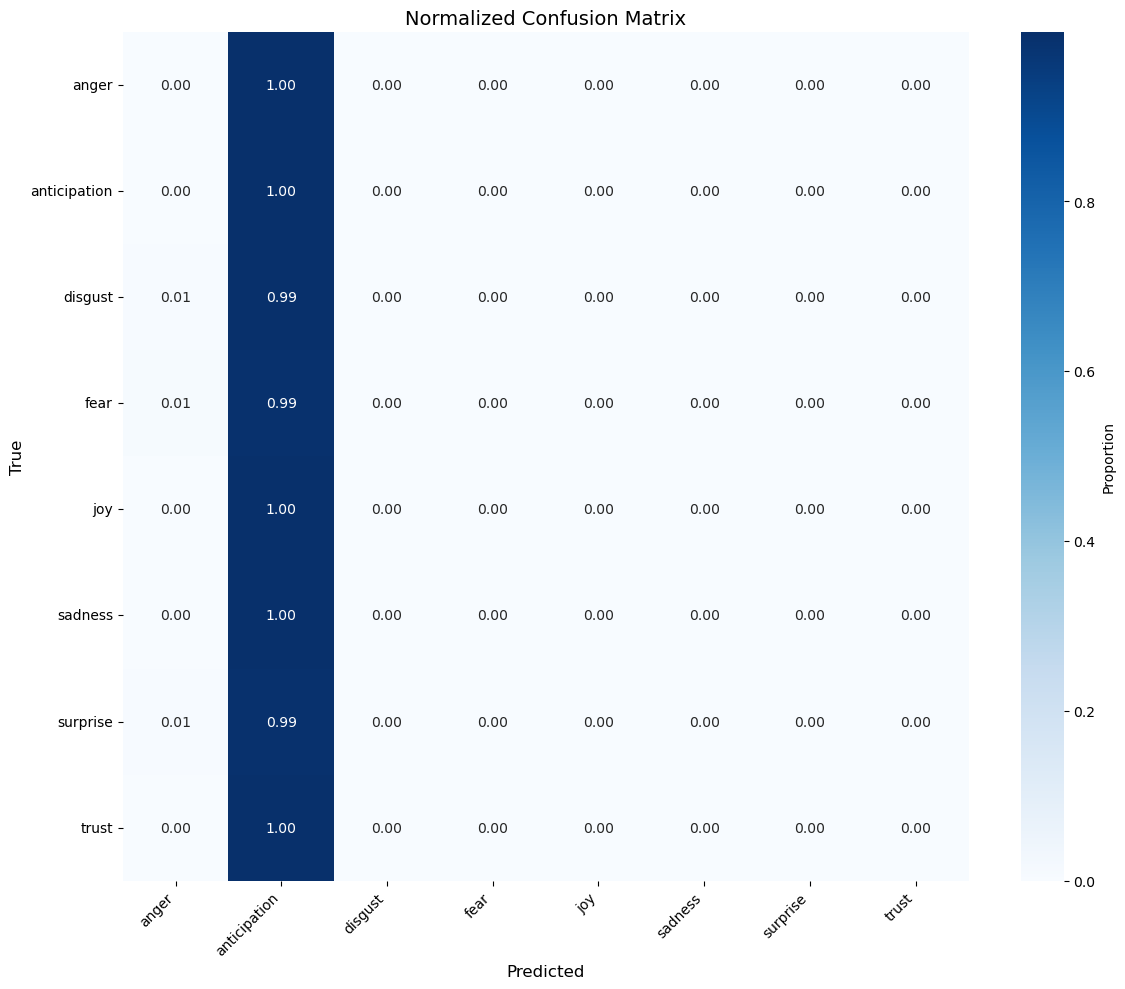

In [ ]:
plot_confusion_matrix(results['confusion_matrix'], fe_labels, normalize=True)